# <center>Rigid Body Replica Exchange

<h1> General Functions

In [ ]:
# Imports
import os, sys, glob
import numpy as np

import ls_parsetxt
import ls_parsepdb

In [ ]:
def removeEndComment(S):
    """
    Removes everything after # sign from a string
    """
    return S.split("#")[0]

# Generate Input

In [ ]:
# Keyword categories
# IO / Run / Thermodynamics / Worlds / Software
class RobosampleInput:
    """
    Hold info in Robosample input file
    """
    
    def __init__(self, molDirs, outDir, writePdbFreq):
        """
        Sets IO parameters
        """
        # IO
        self.molDirs = molDirs
        self.nofMolecules = len(self.molDirs)
        self.outDir = outDir
        self.writePdbFreq = writePdbFreq
        
        # Worlds
        self.nofWorlds = 0
        self.flexFNs = [[None]]
        self.roots = [[None]]
        self.rootMobs = [[None]]
        self.sprs = [None] # samples per round
        
        # Sampling
        self.sampler = None
        self.tss = [None]
        self.mdsteps = [None]
        
        # Thermodynamics
        self.T = [None] # Temperature
        self.bT = [None] # Boost temperature
        self.ffscale = [None] # Force field scale (AMBER = 1)
        self.gbsa = [None] # GBSA scale
        self.fp = [None] # use Fixman potential
        self.ft= [None] # use Fixman torque
        
        # Replica exchange
        self.rexFN = None
        
        # Geometry
        self.geometry = False
        self.distances = [[0, 1]]
        self.dihedrals = [[0, 1, 2, 3]]
    #
    
    def defineWorlds(self, flexFNs, roots, rootMobs, samples_per_round):
        """
        param flexFNs: List of lists of flexibility files (worlds x mols)
        param roots: List of lists of roots
        param rootMobs: List of lists of root mobilities
        param samples_per_round: samples per round
        """
        self.sprs = samples_per_round
        self.nofWorlds = len(self.sprs)
        print(self.nofWorlds, flexFNs, len(flexFNs))
        assert(len(flexFNs) == self.nofMolecules)
        #for molFlexes in flexFNs:
        #    assert(len(molFlexes) == self.nofWorlds)
        assert(len(roots) == self.nofMolecules)
        assert(len(rootMobs) == self.nofMolecules)
        
        
        self.flexFNs = flexFNs
        self.roots = roots
        self.rootMobs = rootMobs
    #
    
    def defineSampling(self, sampler, tss, mdsteps):
        """
        Will use on sampler for all the worlds
        param sampler: sampler name (VV or HMC)
        param tss float: list of integration timesteps for samplers
        param mdsteps: # of integration steps
        """
        self.sampler = sampler
        self.tss = tss
        self.mdsteps = mdsteps
    #
    
    def defineThermodynamics(self, T, bT, ffscale, gbsa, fp, ft):
        self.T = T # Temperature
        self.bT = bT # Boost temperature
        self.ffscale = ffscale # Force field scale (AMBER = 1)
        self.gbsa = gbsa # GBSA scale
        self.fp = fp # use Fixman potential
        self.ft = ft # use Fixman torque
    #

    def defineREX(self, rexFile):
        self.rexFN = rexFile
    #

    def defineGeometry(self, distances, dihedrals):
        """
        distances: list of of 2 atom indexes lists
        dihedrals: list of of 4 atom indexes lists
        """
        self.geometry = True
        self.distances = distances
        self.dihedrals = dihedrals
    #
    
    def dump(self):
        print("IO (mol outDir pdbFreq): ", self.molDirs, self.outDir, self.writePdbFreq)
        print("Worlds flex, roots, samples: \n", self.flexFNs, self.roots, self.rootMobs, self.sprs)
        print("Sampling: ", self.sampler, self.tss, self.mdsteps)
        print("Thermodynamics: T, boostT, ffscale, GBSA, FP, FT", 
              self.T, self.bT, self.ffscale, self.gbsa, self.fp, self.ft)
    #
    
    def generateInput(self, seed, nofRounds):        
            # Params specific to this input
            runStr = "# Run\n"
            runStr += ("SEED " + str(seed) + \
                "\nROUNDS "  + str(nofRounds) + "\n" + \
                """REPRODUCIBLE FALSE
OPENMM TRUE
OPENMM_CalcOnlyNonbonded TRUE
""")
            runStr += "\n"

            # IO
            IOStr = "# IO\n"
            IOStr += "MOLECULES "
            for i in range(self.nofMolecules):
                IOStr += self.molDirs[i]
                
            IOStr += """
PRMTOP ligand.prmtop
INPCRD ligand.rst7
OUTPUT_DIR """ + self.outDir
                
            # Replica exchange
            if self.rexFN != None:
                rexStr = "\n\n# Replica exchange\n"
                rexStr += """RUN_TYPE REX
REX_SWAP_EVERY 1\n"""
                rexStr += ("REX_FILE " + self.rexFN)
            else:
                rexStr = "\n\nRUN_TYPE Normal"
                
            # Worlds flexibilities
            flexStr = "\n\n# Flexibility\n"
            flexStr += "RBFILE "
            for i in range(self.nofWorlds):
                for j in range(self.nofMolecules):
                    flexStr += "ligand.rb "
            flexStr += "\nFLEXFILE "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (self.flexFNs[i][j] + " ")
            flexStr += "\nROOTS "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (str(self.roots[i][j]) + " ")
            flexStr += "\nROOT_MOBILITY "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (self.rootMobs[i][j] + " ")
            flexStr += "\n\n"        
            
            # Worlds
            worldsStr = "# Worlds\nRANDOM_WORLD_ORDER FALSE\n"
            worldsStr += "WORLDS "
            for i in range(self.nofWorlds): worldsStr += (" R" + str(i)) # Only 9 worlds
            worldsStr += "\nTHREADS"
            for i in range(self.nofWorlds): worldsStr += " 0"
            worldsStr += "\nNONBONDED_METHOD"
            for i in range(self.nofWorlds): worldsStr += " 0"
            worldsStr += "\nNONBONDED_CUTOFF"
            for i in range(self.nofWorlds): worldsStr += " 1.2"
            worldsStr += "\nVISUAL "
            for i in range(self.nofWorlds): worldsStr += " FALSE"
            worldsStr += "\nPRINT_FREQ "
            for i in range(self.nofWorlds): worldsStr += " 1"
            worldsStr += "\nROUNDS_TILL_REBLOCK "
            for i in range(self.nofWorlds): worldsStr += " 1"
            worldsStr += "\nSAMPLES_PER_ROUND "
            for i in range(self.nofWorlds): worldsStr += (" " + str(self.sprs[i]))
            worldsStr += "\nWRITEPDBS " + str(self.writePdbFreq)
            for i in range(self.nofWorlds - 1): worldsStr += " 0"
            worldsStr += "\n\n"

            # Geometry
            geomStr = "\nGEOMETRY "
            if self.geometry:
                for i in range(self.nofWorlds): geomStr += " TRUE"
            else:
                for i in range(self.nofWorlds): geomStr += " FALSE"
            geomStr += "\nDISTANCE "        
            for i in range(len(self.distances)):
                for j in range(len(self.distances[i])):
                    geomStr += (" " + str(self.distances[i][j]))
            geomStr += "\nDIHEDRAL "        
            for i in range(len(self.dihedrals)):
                for j in range(len(self.dihedrals[i])):
                    geomStr += (" " + str(self.dihedrals[i][j]))
                


            # Sampling
            samStr = "\n\n# Sampling\n"
            samStr += "SAMPLER "
            for i in range(self.nofWorlds): samStr += (" " + self.sampler)
            samStr += "\nTIMESTEPS "
            for i in range(self.nofWorlds): samStr += (" " + str(self.tss[i]))
            samStr += "\nMDSTEPS "
            for i in range(self.nofWorlds): samStr += (" " + str(self.mdsteps[i]))
            samStr += "\nBOOST_MDSTEPS "
            for i in range(self.nofWorlds): samStr += " 1"
            samStr += "\nNMA_OPTION "
            for i in range(self.nofWorlds): samStr += " 0"

            # Thermodynamics
            thermoStr = "\n\n# Thermodynamics\nTHERMOSTAT "
            for i in range(self.nofWorlds): thermoStr += " Andersen"            
            thermoStr += "\nTEMPERATURE_INI "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.T[i]))
            thermoStr += "\nTEMPERATURE_FIN "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.T[i]))
            thermoStr += "\nBOOST_TEMPERATURE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.bT[i]))
            thermoStr += "\nFFSCALE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.ffscale[i]))
            thermoStr += "\nGBSA "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.gbsa[i]))
            thermoStr += "\nFIXMAN_POTENTIAL "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.fp[i]))
            thermoStr += "\nFIXMAN_TORQUE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.ft[i]))


                
            return runStr + IOStr + rexStr + flexStr + worldsStr + geomStr + samStr + thermoStr
        
        

    

In [ ]:
# Replica exchange protocol
class REXProtocol:
    """
    Replica exchange protocol
    
    Given N worlds defined and K replicas, we need a 
    K x Nmax table of worlds per replica, where Nmax is 
    maximum nof worlds in a replica.
    
    Equivalent tables of timesteps, MD steps and samples per rounds
    are needed
    """    
    def __init__(self, Ti, Tf, nofWantedReplicas, distribution = "geometric"):
        """
        Generates a geometric distribution of Ts
        """
        self.nofReplicas = nofWantedReplicas
        self.Ts = []
        self.Ts.append(Ti)
        
        if(distribution == "geometric"):
            # Generate geometric distribution
            r = (Tf / Ti)**(1 / (nofWantedReplicas - 1)) # rate parameter
            for i in range(1, nofWantedReplicas):
                self.Ts.append(self.Ts[i-1] * r)
        else:
            self.Ts.append(Tf)
        
        self.Ts = np.array(self.Ts)
    #

    def getTs(self):
            return self.Ts
    #
    
    def loadWorldParams(self, worlds, tss, mdsteps, sprs):
        """
        Generates the tables of parameters for every world
        """
        assert(len(worlds) == self.nofReplicas)
        assert(len(tss) == len(mdsteps) == len(sprs) == len(worlds))
        
        self.rexWorlds = worlds
        self.rexTss = tss
        self.rexMdsteps = mdsteps
        self.rexSprs = sprs
    #    
    
    def generateTrexContent(self):
        """
        Write trex file
        param rexWorlds: list of worlds lists for each replica
        """
        assert(self.nofReplicas == len(rexWorlds))
        self.rexWorlds = rexWorlds
        rexStr = "NOF_REPLICAS " + str(self.nofReplicas) + "\n#Title\n"
        for i in range(self.nofReplicas):
            rexStr += (str(i) + " TEMPERATURE " + str((self.Ts[i]))) + "\n"
            rexStr += str(i) + " WORLD_INDEXES"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexWorlds[i][j])
            rexStr += "\n" + str(i) + " TIMESTEPS"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexTss[i][j])
            rexStr += "\n" + str(i) + " MDSTEPS"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexMdsteps[i][j])
            rexStr += "\n" + str(i) + " SAMPLES_PER_ROUND"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexSprs[i][j])                
            rexStr += "\n#\n"            
            
        return rexStr
    #

In [94]:
# IO and MOLECULE
molDirs = ["ala1"]
outDir = "temp"
writePdbFreq = 0

nofMols = len(molDirs)

# Experiment global parameters
nofRepeats = 10

# Regimens
IC = 0; TD = 1; RM = 2
regimens = np.array([IC, TD, RM], dtype = int)
regimenNames = ["ic", "td", "rm"]
usingFixman = ["FALSE", "TRUE", "TRUE"]
allFlexFNs = ["ligand.flex.cart", "ligand.flex.7td", "ligand.flex.2td"]

nofRegimens = regimens.size

# Seeds
seeds = np.zeros((nofRegimens, nofRepeats), dtype = int)
for regimen in range(nofRegimens):
    seeds[regimen] = (1000 * (regimen+1)) + np.arange(0, 10, 1)
print("seeds: ", seeds)

# Default world parameters
optimTss = np.array([0.0007, 0.003, 0.007])
optimMdsteps = np.array([300, 70, 30])

#############
#### REX ####
#############
nofReplicas = 4
rexWorlds = [[0,1], [0, 2], [0, 2], [0, 2]]

# Timesteps
rexTss = [None] * nofRegimens # timesteps
rexTss[IC] = [[optimTss[IC], optimTss[IC]]]
rexTss[TD] = [[optimTss[IC], optimTss[IC]]]
rexTss[RM] = [[optimTss[IC], optimTss[IC]]]

rexTss[IC] += [[optimTss[IC], optimTss[IC]] for i in range(nofReplicas - 1)]
rexTss[TD] += [[optimTss[IC], optimTss[TD]] for i in range(nofReplicas - 1)]
rexTss[RM] += [[optimTss[IC], optimTss[RM]] for i in range(nofReplicas - 1)]

# MD steps
rexMdsteps = [None] * nofRegimens # nof MD steps
rexMdsteps[IC] = [[0, 300]]
rexMdsteps[TD] = [[0, 300]]
rexMdsteps[RM] = [[0, 300]]

rexMdsteps[IC] += [[0, 300] for i in range(nofReplicas - 1)]
rexMdsteps[TD] += [[0, 70]  for i in range(nofReplicas - 1)]
rexMdsteps[RM] += [[0, 30]  for i in range(nofReplicas - 1)]

# Samples per round
rexSprs = [None] * nofRegimens 
rexSprs[IC] = [[1, 1], [1, 1], [1, 1], [1, 1]]
rexSprs[TD] = rexSprs[IC]
rexSprs[RM] = rexSprs[IC]

rexProtocol = REXProtocol(300, 450, nofReplicas)
Ts = rexProtocol.getTs()
print(Ts)

# Write trex files
trexFNs = []
for regimen in regimens:
    rexProtocol.loadWorldParams(rexWorlds, rexTss[regimen], rexMdsteps[regimen], rexSprs[regimen])    
    REXFContent = rexProtocol.generateTrexContent()
    trexFNs.append("trex." + regimenNames[regimen] + ".dT200.dat")
    #with open(trexFNs[-1], 'w') as F:
    #    F.write(REXFContent)


seeds:  [[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009]
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]
 [3000 3001 3002 3003 3004 3005 3006 3007 3008 3009]]
[300.         343.41427277 393.11120913 450.        ]


<h2> Generate inputs </h2>

In [96]:
# Roots
roots = [[0 for i in range(nofRegimens)] for j in range(nofMols)]
rootMobs = [["Weld" for i in range(nofRegimens)] for j in range(nofMols)]

# Sampling
sampler ="HMC"
tss = [0.001 for i in range(nofRegimens)]
mdsteps = [10 for i in range(nofRegimens)]
sprs = [1 for i in range(nofRegimens)] # sampler per round

# Thermodynamics
T = [300.0 for i in range(nofRegimens)]
bT = [300.0 for i in range(nofRegimens)]
ffscale = ["AMBER" for i in range(nofRegimens)]
gbsa = [0.0 for i in range(nofRegimens)]
fp = usingFixman
ft = usingFixman

# Geometry
alaDistances = [[1, 18]]
alaDihedrals = [[4, 6, 8, 14], [6, 8, 14, 16]]

dT = int(200.0)

# REX things

# Worlds
nofRounds = 10000

# Write inp and batch files
for regimen in regimens:
    trexFN = trexFNs[regimen]
    flexFNs = [[allFlexFNs[0], allFlexFNs[0], allFlexFNs[regimen]]]

    roboInput = RobosampleInput(molDirs, outDir, writePdbFreq)
    roboInput.defineREX(trexFN)
    roboInput.defineWorlds(flexFNs, roots, rootMobs, sprs)
    roboInput.defineSampling(sampler, tss, mdsteps)
    roboInput.defineThermodynamics(T, bT, ffscale, gbsa, fp, ft)
    roboInput.defineGeometry(alaDistances, alaDihedrals)
    #roboInput.dump()

    batchStr = ""
    for seed in seeds[regimen]:        
        specStr = regimenNames[regimen] + ".dT" + str(dT) + "." + str(seed)
        inFN = "inp."
        outFN = "out."
        inFN += specStr
        outFN += specStr

        print(inFN, outFN)
        
        FContent = roboInput.generateInput(seed, nofRounds)
        #with open(inFN, 'w') as F:
        #    F.write(FContent)
        
        batchStr += "nohup /home/laurentiu/git4/Robosample/build/release/robosample/src/GMOLMODEL_robo "
        batchStr += inFN
        batchStr += (" > " + outFN + " 2>&1 &\n")
        
    batchFN = "batch." + regimenNames[regimen] + ".bash"
    print(batchFN)
    
    #with open(batchFN, "w") as batchF:
    #    batchF.write(batchStr)


3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.cart']] 1
inp.ic.dT200.1000 out.ic.dT200.1000
inp.ic.dT200.1001 out.ic.dT200.1001
inp.ic.dT200.1002 out.ic.dT200.1002
inp.ic.dT200.1003 out.ic.dT200.1003
inp.ic.dT200.1004 out.ic.dT200.1004
inp.ic.dT200.1005 out.ic.dT200.1005
inp.ic.dT200.1006 out.ic.dT200.1006
inp.ic.dT200.1007 out.ic.dT200.1007
inp.ic.dT200.1008 out.ic.dT200.1008
inp.ic.dT200.1009 out.ic.dT200.1009
batch.ic.bash
3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.7td']] 1
inp.td.dT200.2000 out.td.dT200.2000
inp.td.dT200.2001 out.td.dT200.2001
inp.td.dT200.2002 out.td.dT200.2002
inp.td.dT200.2003 out.td.dT200.2003
inp.td.dT200.2004 out.td.dT200.2004
inp.td.dT200.2005 out.td.dT200.2005
inp.td.dT200.2006 out.td.dT200.2006
inp.td.dT200.2007 out.td.dT200.2007
inp.td.dT200.2008 out.td.dT200.2008
inp.td.dT200.2009 out.td.dT200.2009
batch.td.bash
3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.2td']] 1
inp.rm.dT200.3000 out.rm.dT200.3000
inp.rm.dT200.3001

# Analyze Output

In [ ]:
!ls

In [ ]:

#print(FNList)

# Fixed number of worlds per replica 
nofWorldsPerReplica = np.max([len(w) for w in rexWorlds])

#nofWorlds = 0
#with open("inp.ic.dT200.1000", "r") as F:
#    all_lines = F.readlines()
#    linei = -1
#    for line in all_lines:
#        linei += 1
#        line = removeEndComment(line)
#        if(len(line) > 1):
#            words = line.split()
#            if words[0][0] != "#":
#                if words[0] == "WORLDS":
#                    nofWorlds = len(words) - 1

print("nof worlds per replica", nofWorldsPerReplica)

<h2> Check trex file </h2>

In [119]:
# Check trex files

def checkTrex(trexFN):
    
    Ts = np.zeros((1))
    worlds = np.zeros((1, nofWorldsPerReplica))
    tss = np.zeros((1, nofWorldsPerReplica))
    mdsteps = np.zeros((1, nofWorldsPerReplica))
    spr = np.zeros((1, nofWorldsPerReplica))
    
    with open(trexFN, "r") as F:
        all_lines = F.readlines()
        linei = -1
        for line in all_lines:
            linei += 1
            words = line.split()
            if words[0][0] != "#":
                if words[0] == "NOF_REPLICAS":
                    nofReplicas = int(words[1])
                    Ts.resize((nofReplicas))
                    worlds.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                    tss.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                    mdsteps.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                    spr.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                else:
                    if not nofReplicas:
                        "NOF_REPLICAS not set first in grex file."
                        break
                    else:
                        K = int(words[0])
                        if words[1] == "TEMPERATURE":
                            Ts[K] = float(words[2])
                        
                        elif words[1] == "WORLD_INDEXES":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                worlds[K, wi] = words[2+wi]

                        elif words[1] == "TIMESTEPS":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                tss[K, wi] = words[2+wi]
                                
                        elif words[1] == "MDSTEPS":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                mdsteps[K, wi] = words[2+wi]
                                
                        elif words[1] == "SAMPLES_PER_ROUND":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                spr[K, wi] = words[2+wi]                        

    print("nofReplicas", nofReplicas)                                    
    print("Ts", Ts)
    print("worlds", worlds)
    print("tss", tss)
    print("mdsteps", mdsteps)
    print("spr", spr)

trexFN = "trex.rm.dT200.dat"    
checkTrex(trexFN)    



nofReplicas 4
Ts [300.         343.41427277 393.11120913 450.        ]
worlds [[0. 1.]
 [0. 2.]
 [0. 2.]
 [0. 2.]]
tss [[0.0007 0.0007]
 [0.0007 0.007 ]
 [0.0007 0.007 ]
 [0.0007 0.007 ]]
mdsteps [[  0. 300.]
 [  0.  30.]
 [  0.  30.]
 [  0.  30.]]
spr [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


<h2> Function: Get Data from an output file </h2>

In [ ]:
# Get output
def getOutputData(outFN, outD):
    """
    Read data from an Robosample output file outFN
    and put it in a numpy array outD
    """
    batchi = -1
    with open(outFN, "r") as F:
        all_lines = F.readlines()
        linei = -1
        for line in all_lines:
            linei += 1
            line.replace(" ", "").replace(",", "",100)
            words = line.split()
            if  (words[0] == "REX") and (words[1] == "batch"):
                batchi += 1
                replicai = -1
            elif (words[0] == "REX") and (words[1] == "replica"):
                replicai += 1
                worldi = -1            
            elif (words[0] == "Temperature") and (words[1] == "set") and (words[2] == "to"):
                for j in range(nofWorldsPerReplica):
                    outD[batchi][replicai][j][0] = float(words[3])                
            elif (words[0] == "World") and (words[2] == "NU"):
                worldi += 1
            elif(words[0] == "pe_o"):
                pe_o = float(words[1].replace(",", ""))
                pe_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][1] = pe_o
                outD[batchi][replicai][worldi][2] = pe_n

            elif(words[0] == "ke_prop"):
                ke_prop = float(words[1].replace(",", ""))
                ke_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][3] = ke_prop
                outD[batchi][replicai][worldi][4] = ke_n

            elif(words[0] == "fix_o"):
                fix_o = float(words[1].replace(",", ""))
                fix_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][5] = fix_o
                outD[batchi][replicai][worldi][6] = fix_n

            elif (len(words) > 2) and (words[2] == "(metropolis-hastings)"):
                if words[1] == "accepted":
                    acc = 1.0
                else:
                    acc = 0.0
                outD[batchi][replicai][worldi][7] = acc
            
            #if linei > 500:
            #    print(outD)
            #    break
            
        return outD
#

      

<h2>Get Output Data</h2>

Get output data , thermodynamic state data and their correspondence (mix)

In [191]:
# Get output data , thermodynamic state data and their correspondence (mix)

# Indeces
nofIndexes = 8
Ix_T = 0
Ix_pe_o = 1
Ix_pe_n = 2
Ix_ke_prop = 3
Ix_ke_n = 4
Ix_fix_o = 5
Ix_fix_n = 6
Ix_acc = 7

# Output data
outD = np.zeros((nofRegimens, nofRepeats, nofRounds, nofReplicas, nofWorldsPerReplica, nofIndexes), dtype = float) * np.nan
thermoStateD = np.zeros(outD.shape, dtype = float) * np.nan
mix = np.zeros((nofRegimens, nofRepeats, nofRounds, nofReplicas)) * np.nan

FNList = glob.glob("out.*")
print(FNList)

for regimen in range(nofRegimens):
    for repeat in range(nofRepeats): 
        outFN = "out." + regimenNames[regimen] + ".dT200." + str(seeds[regimen, repeat])
        print(outFN)
        outD[regimen, repeat] = getOutputData(outFN, outD[regimen, repeat])

        # Thermodynamic state data and correspondence
        batchi = -1
        for D in outD[regimen, repeat]:
            batchi += 1
            replicai = -1
            for replica in D:
                #print(replica)
                replicai += 1
                for tix in range(Ts.size):
                    if (replica[0, 0] - Ts[tix]) < 0.000001:
                        thermoStateD[regimen, repeat, batchi, tix] = replica
                        mix[regimen, repeat, batchi, tix] = replicai
                        break
                
        #print(outD[regimen, repeat][0:2])
        #print(mix[regimen, repeat])


['out.ic.dT200.1000', 'out.ic.dT200.1001', 'out.ic.dT200.1002', 'out.ic.dT200.1003', 'out.ic.dT200.1004', 'out.ic.dT200.1005', 'out.ic.dT200.1006', 'out.ic.dT200.1007', 'out.ic.dT200.1008', 'out.ic.dT200.1009', 'out.rm.dT200.3000', 'out.rm.dT200.3001', 'out.rm.dT200.3002', 'out.rm.dT200.3003', 'out.rm.dT200.3004', 'out.rm.dT200.3005', 'out.rm.dT200.3006', 'out.rm.dT200.3007', 'out.rm.dT200.3008', 'out.rm.dT200.3009', 'out.td.dT200.2000', 'out.td.dT200.2001', 'out.td.dT200.2002', 'out.td.dT200.2003', 'out.td.dT200.2004', 'out.td.dT200.2005', 'out.td.dT200.2006', 'out.td.dT200.2007', 'out.td.dT200.2008', 'out.td.dT200.2009']
out.ic.dT200.1000
out.ic.dT200.1001
out.ic.dT200.1002
out.ic.dT200.1003
out.ic.dT200.1004
out.ic.dT200.1005
out.ic.dT200.1006
out.ic.dT200.1007
out.ic.dT200.1008
out.ic.dT200.1009
out.td.dT200.2000
out.td.dT200.2001
out.td.dT200.2002
out.td.dT200.2003
out.td.dT200.2004
out.td.dT200.2005
out.td.dT200.2006
out.td.dT200.2007
out.td.dT200.2008
out.td.dT200.2009
out.rm.dT

[1. 1. 1. ... 1. 1. 1.]


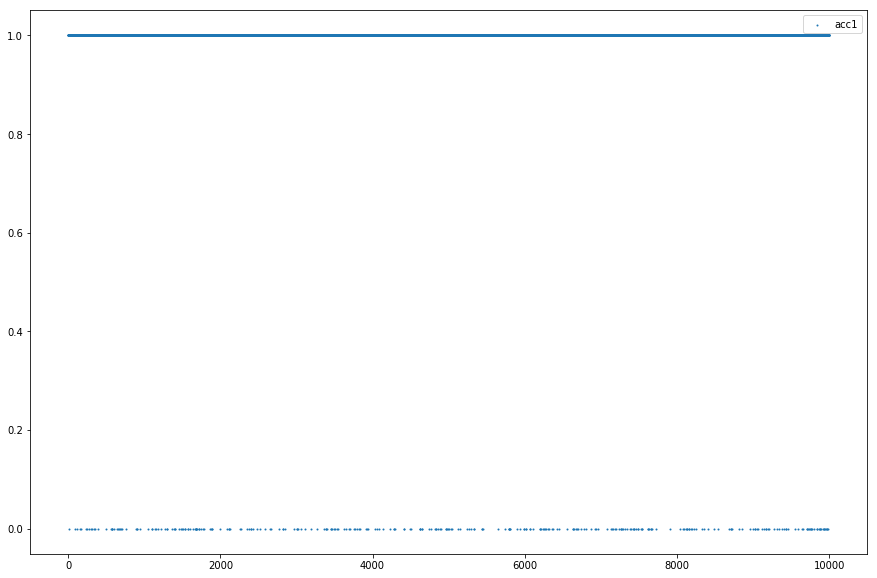

In [192]:
import matplotlib
import matplotlib.pyplot as plt

# Plot random timeseries here
regimen = 0
repeat = 0

colData = [None] * nofReplicas
Ix_colData = 7 # acceptance
worldIx = 1 # Acceptance is less than 1 in world 1

replicaRange = range(1, 2)
#for k in range(nofReplicas):
for k in replicaRange:

    colData[k] = thermoStateD[regimen, repeat,:, k, worldIx, Ix_colData]
    print(colData[k])
    colData[k] = colData[k][np.logical_not(np.isnan(colData[k]))]
        
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(1, 1)
for k in replicaRange:
    axs.scatter(range(colData[k].size), colData[k], s = 1, label = "acc" + str(k))
plt.legend()
plt.show()    

In [193]:
def thermoStatesHistogram(data, worldIx, dataIx, nbins = 20, histRange = None):
    """
    Extracts data and returns histograms
    """
    data_min = None
    data_max = None
    histStep = None
    
    if histRange == None:
        data_min = np.nanmin(data[:, :, :, :, worldIx, dataIx])
        data_max = np.nanmax(data[:, :, :, :, worldIx, dataIx])
        histRange = (data_min, data_max)
    else:
        data_min = histRange[0]
        data_max = histRange[1]
    
    histStep = (data_max - data_min) / nbins
        
    XAxis = np.arange(data_min, data_max, histStep)

    smallDataHists = np.zeros((nofRepeats, nofReplicas, nbins), dtype=float) * np.nan
    smallDataHistsAvg = np.zeros((nofReplicas, nbins))
    smallDataHistsStd = np.zeros((nofReplicas, nbins))

    smallData = [None] * nofReplicas

    for repeat in range(nofRepeats):
        for k in range(nofReplicas):
            smallData[k] = data[regimen, repeat, :, k, worldIx, Ix_ke_prop]
            smallData[k] = smallData[k][np.logical_not(np.isnan(smallData[k]))]
            smallDataHists[repeat, k] = np.histogram(smallData[k], bins = nbins, range = histRange)[0]
        
    for k in range(nofReplicas):
        smallDataHistsAvg[k] = np.mean(smallDataHists[:, k], axis = 0)
        smallDataHistsStd[k] = np.std(smallDataHists[:, k], axis = 0)        
    
    return (XAxis, smallDataHistsAvg, smallDataHistsStd)
#

<h2> Kinetic Energy

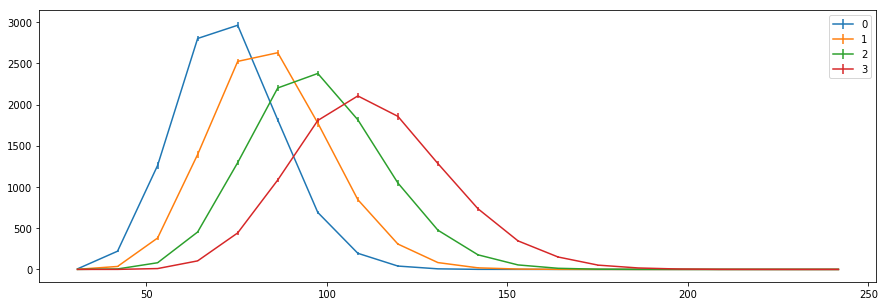

In [194]:
regimen = RM
repeat = 0

# Kinetic energy
worldIx = 0 # Full proposed KE is only in world 0
nbins = 20
(XAxis, KHistsAvg, KHistsStd) = thermoStatesHistogram(thermoStateD, worldIx, Ix_ke_prop, nbins = nbins)    
    
    
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    axs.errorbar(XAxis, KHistsAvg[k], yerr = KHistsStd[k], label = str(k))
plt.legend()
plt.show()


<h1>  Potential Energy

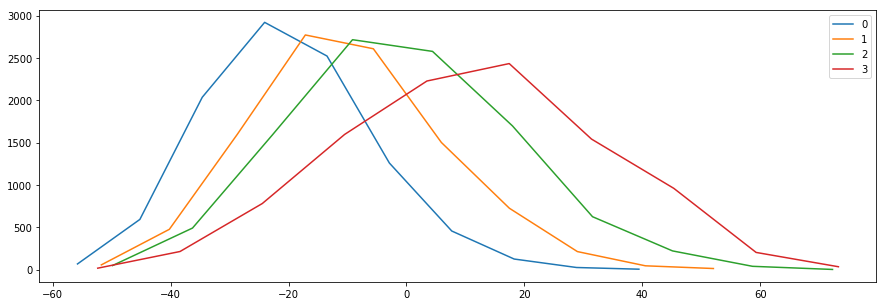

In [195]:
regimen = RM
repeat = 0

# Potential energy
worldIx = 0 # Full PE is only in world 0
nbins = 20
(XAxis, UHistsAvg, UHistsStd) = thermoStatesHistogram(thermoStateD, worldIx, Ix_pe_o, nbins = nbins)       
       
# Plot    
fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    axs.plot(UHists[k][1][:-1], UHists[k][0], label = str(k))
plt.legend()
plt.show()

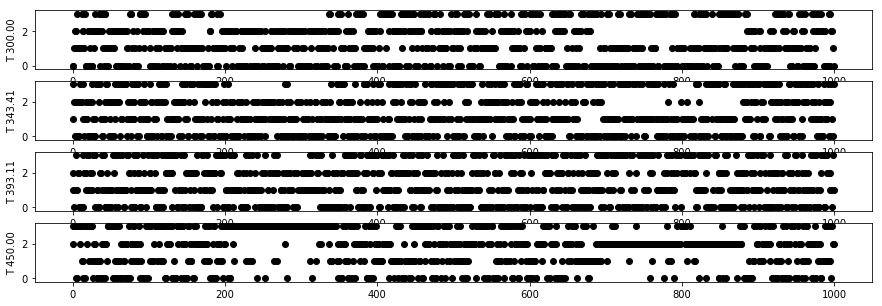

In [196]:
stride = 10
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(4, 1)
for k in range(nofReplicas):
    #axs[k].plot(range(len(mix[regimen, repeat,:,k][::stride])), mix[regimen, repeat,:,k][::stride], color = 'black')
    axs[k].scatter(range(len(mix[regimen, repeat,:,k][::stride])), mix[regimen, repeat,:,k][::stride], color = 'black')
    axs[k].set_ylabel("T " + str("%.2f" % Ts[k]))
    
plt.show()

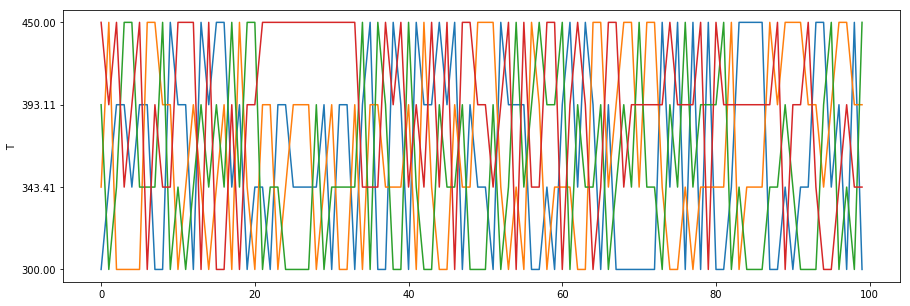

In [197]:
fig, axs = plt.subplots(1, 1)
stride = 100
for k in range(nofReplicas):
    #axs.scatter(range(len(mix[regimen, repeat,:,k][0:-1:stride])), mix[regimen, repeat,:,k][0:-1:stride])
    axs.plot(range(len(mix[regimen, repeat,:,k][0:-1:stride])), mix[regimen, repeat,:,k][0:-1:stride])
axs.set_ylabel("T")
axs.set_yticks(range(Ts.size))
axs.set_yticklabels([("%.2f" % Ts[k]) for k in range(nofReplicas)])
    
plt.show()

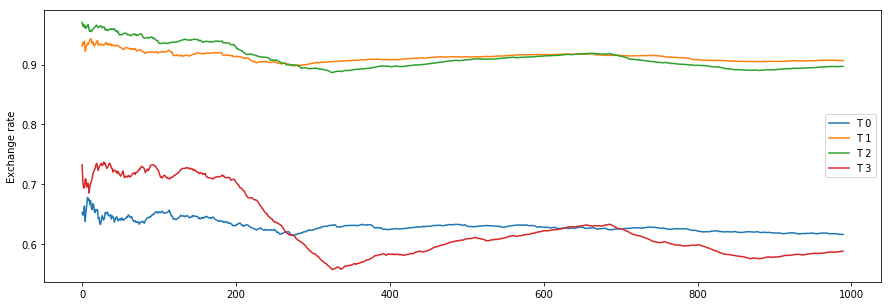

In [199]:

xrate = np.zeros(mix.shape, dtype = float)
# Create v with arange ... is better
v = np.ones(xrate.shape, dtype = float)

regimen = RM
repeat = 0

for i in range(1, xrate.shape[2]):
    for j in range(xrate.shape[3]):
        v[regimen, repeat, i, j] += v[regimen, repeat, i-1, j]
        # Check if exchange happend
        if mix[regimen, repeat, i-1, j] != mix[regimen, repeat, i, j]:
            xrate[regimen, repeat, i, j] = xrate[regimen, repeat, i-1, j] + 1.0
        else:
            xrate[regimen, repeat, i, j] = xrate[regimen, repeat, i-1, j]

xrate /= v

colors = ["blue"]

fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    axs.plot(xrate[regimen, repeat, :,k][::10][10:], label = "T " + str(k))
    axs.set_ylabel("Exchange rate")
    
plt.legend()    
plt.show()